#Download and unzip dataset

In [ ]:
! pip install -q kaggle
!pip install visualkeras
! pip install ann_visualizer
from google.colab import files
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.0/993.0 kB 32.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for ann_visualizer: filename=ann_visualizer-2.5-py3-none-any.whl size=4167 sha256=b34e2a004bbfe5e67d94cb7ba2ed0335f6457d5fd6d82a287a28ae010b42de0e
  Stored in directory: /root/.cache/pip/wheels/6e/0f/ae/f5dba91db71b1b32bf03d0ad18c32e86126093aba5ec6b6488
Successfully built ann_visualizer
100% 284M/285M [00:09<00:00, 35.0MB/s]
100% 285M/285M [00:09<00:00, 32.1MB/s]


In [ ]:
!unzip /content/challenges-in-representation-learning-facial-expression-recognition-challenge.zip

Archive:  /content/challenges-in-representation-learning-facial-expression-recognition-challenge.zip
  inflating: example_submission.csv  
  inflating: fer2013.tar.gz          
  inflating: icml_face_data.csv      
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
!tar -xf /content/fer2013.tar.gz

#Import libraries

In [ ]:
import tensorflow as tf

import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Dense, Activation, Dropout, Flatten
from tensorflow.keras.layers import BatchNormalization
import visualkeras

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image


#CPU & GPU config

In [ ]:
config = tf.compat.v1.ConfigProto( device_count = {'GPU': 1 , 'CPU': 56} ) #max: 1 gpu, 56 cpu
sess = tf.compat.v1.Session(config=config)
keras.backend.set_session(sess)

#Variables

In [ ]:
num_classes = 7
batch_size = 64
epochs = 20

#Read dataset

In [ ]:
with open("/content/fer2013/fer2013.csv") as f:
    content = f.readlines()

lines = np.array(content)

num_of_instances = lines.size
print("number of instances: ",num_of_instances)
print("instance length: ",len(lines[1].split(",")[1].split(" ")))

number of instances:  35888
instance length:  2304
0


#initialize trainset and test set

In [ ]:
x_train, y_train, x_test, y_test = [], [], [], []

#Transfer train and test set data

In [ ]:
for i in range(1,num_of_instances):
    try:
        emotion, img, usage = lines[i].split(",")

        val = img.split(" ")

        pixels = np.array(val, 'float32')

        emotion = keras.utils.to_categorical(emotion, num_classes)

        if 'Training' in usage:
            y_train.append(emotion)
            x_train.append(pixels)
        elif 'PublicTest' in usage:
            y_test.append(emotion)
            x_test.append(pixels)
    except:
	      print("",end="")

#Data transformation for train and test sets

In [ ]:
x_train = np.array(x_train, 'float32')
y_train = np.array(y_train, 'float32')
x_test = np.array(x_test, 'float32')
y_test = np.array(y_test, 'float32')
print('Before normalizing:')
print(x_train)
x_train /= 255 #normalize inputs between [0, 1]
x_test /= 255
print('After normalizing:')
print(x_train)

print('Before reshape:', x_train.shape)
x_train = x_train.reshape(x_train.shape[0], 48, 48, 1)
x_train = x_train.astype('float32')
x_test = x_test.reshape(x_test.shape[0], 48, 48, 1)
x_test = x_test.astype('float32')
print('After reshape:',x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

Before normalizing:
[[ 70.  80.  82. ... 106. 109.  82.]
 [151. 150. 147. ... 193. 183. 184.]
 [231. 212. 156. ...  88. 110. 152.]
 ...
 [ 74.  81.  87. ... 188. 187. 187.]
 [222. 227. 203. ... 136. 136. 134.]
 [195. 199. 205. ...   6.  15.  38.]]
After normalizing:
[[0.27450982 0.3137255  0.32156864 ... 0.41568628 0.42745098 0.32156864]
 [0.5921569  0.5882353  0.5764706  ... 0.75686276 0.7176471  0.72156864]
 [0.90588236 0.83137256 0.6117647  ... 0.34509805 0.43137255 0.59607846]
 ...
 [0.2901961  0.31764707 0.34117648 ... 0.7372549  0.73333335 0.73333335]
 [0.87058824 0.8901961  0.79607844 ... 0.53333336 0.53333336 0.5254902 ]
 [0.7647059  0.78039217 0.8039216  ... 0.02352941 0.05882353 0.14901961]]
Before reshape: (28709, 2304)
After reshape: (28709, 48, 48, 1)
28709 train samples
3589 test samples


#Construct CNN Structure

In [ ]:
# Define the model architecture
model = Sequential()

# Add a convolutional layer with 32 filters (neurons), 3x3 kernel size, and relu activation function
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48,48,1)))
# Add a batch normalization layer
model.add(BatchNormalization())
# Add a second convolutional layer with 64 filters, 3x3 kernel size, and relu activation function
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
# Add a second batch normalization layer
model.add(BatchNormalization())
# Add a max pooling layer with 2x2 pool size
model.add(MaxPooling2D(pool_size=(2, 2)))
# Add a dropout layer with 0.25 dropout rate
model.add(Dropout(0.25))
# print(model.layers[5].output)

# Add a third convolutional layer with 128 filters, 3x3 kernel size, and relu activation function
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
# Add a third batch normalization layer
model.add(BatchNormalization())
# Add a fourth convolutional layer with 128 filters, 3x3 kernel size, and relu activation function
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
# Add a fourth batch normalization layer
model.add(BatchNormalization())
# Add a max pooling layer with 2x2 pool size
model.add(MaxPooling2D(pool_size=(2, 2)))
# Add a dropout layer with 0.25 dropout rate
model.add(Dropout(0.25))

# Add a fifth convolutional layer with 256 filters, 3x3 kernel size, and relu activation function
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
# Add a fifth batch normalization layer
model.add(BatchNormalization())
# Add a sixth convolutional layer with 256 filters, 3x3 kernel size, and relu activation function
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
# Add a sixth batch normalization layer
model.add(BatchNormalization())
# Add a max pooling layer with 2x2 pool size
model.add(MaxPooling2D(pool_size=(2, 2)))
# Add a dropout layer with 0.25 dropout rate
model.add(Dropout(0.25))

# Flatten the output of the convolutional layers
model.add(Flatten())
# Add a dense layer with 256 neurons and relu activation function
model.add(Dense(256, activation='relu'))
# Add a seventh batch normalization layer
model.add(BatchNormalization())
# Add a dropout layer with 0.5 dropout rate
model.add(Dropout(0.5))
# Add a dense layer with 7 neurons (one for each class) and softmax activation function
model.add(Dense(num_classes, activation='softmax'))


# first_param = list(model.layers[22].get_weights())[0]
# print(first_param)

#Visualize CNN Model Structure.

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 46, 46, 32)        320       
                                                                 
 batch_normalization_7 (Batc  (None, 46, 46, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 44, 44, 64)        18496     
                                                                 
 batch_normalization_8 (Batc  (None, 44, 44, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 22, 22, 64)       0         
 2D)                                                             
                                                      

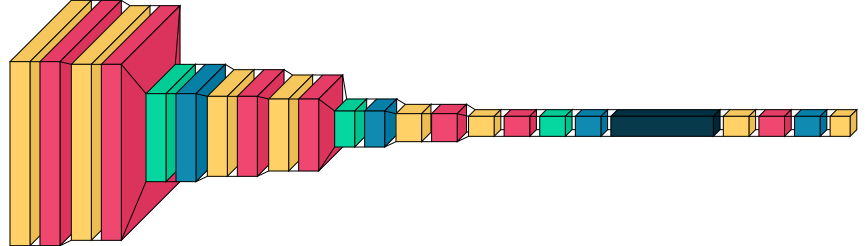

In [ ]:
# visualkeras.layered_view(model).show() # display using your system viewer
# visualkeras.layered_view(model, to_file='output.png') # write to disk
# visualkeras.layered_view(model, to_file='output.png').show() # write and show
model.summary()

visualkeras.layered_view(model)

#Batch process

In [ ]:
tf.random.set_seed(101)

model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(0.0001), #0.001
              metrics=['accuracy'])

print('for batchsize = ' , batch_size , ' and epochs = ' , epochs , ': ')
history = model.fit(x= x_train, y=y_train, validation_data=(x_test, y_test), epochs=epochs)
model.save('model.h5')

for batchsize =  64  and epochs =  20 : 
Epoch 1/20
898/898 [==============================] - 17s 17ms/step - loss: 2.5344 - accuracy: 0.2259 - val_loss: 1.6789 - val_accuracy: 0.3656
Epoch 2/20
898/898 [==============================] - 15s 17ms/step - loss: 2.0803 - accuracy: 0.3082 - val_loss: 1.5586 - val_accuracy: 0.4160
Epoch 3/20
898/898 [==============================] - 15s 17ms/step - loss: 1.8398 - accuracy: 0.3618 - val_loss: 1.4570 - val_accuracy: 0.4511
Epoch 4/20
898/898 [==============================] - 16s 17ms/step - loss: 1.6862 - accuracy: 0.4024 - val_loss: 1.4080 - val_accuracy: 0.4742
Epoch 5/20
898/898 [==============================] - 16s 18ms/step - loss: 1.5587 - accuracy: 0.4311 - val_loss: 1.3561 - val_accuracy: 0.4887
Epoch 6/20
898/898 [==============================] - 15s 17ms/step - loss: 1.4612 - accuracy: 0.4588 - val_loss: 1.2751 - val_accuracy: 0.5202
Epoch 7/20
898/898 [==============================] - 15s 17ms/step - loss: 1.3841 - accuracy: 

In [ ]:
print('for batchsize =' , batch_size , 'and epochs =' , epochs , ': ')

train_score = model.evaluate(x_train, y_train, verbose=0)
print('Train loss:', train_score[0])
print('Train accuracy:', 100*train_score[1])

test_score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', test_score[0])
print('Test accuracy:', 100*test_score[1])

for batchsize = 64 and epochs = 20 : 
Train loss: 0.5737507343292236
Train accuracy: 80.6332528591156
Test loss: 1.07930588722229
Test accuracy: 61.382001638412476


In [ ]:
# print(history.history.keys())

for batchsize =  64  and epochs =  20 : 


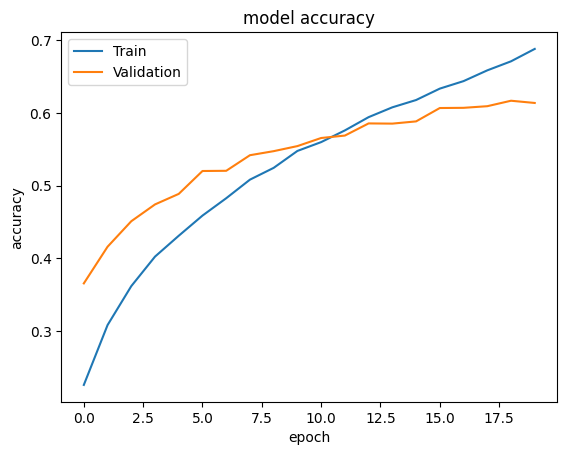

for batchsize =  64  and epochs =  20 : 


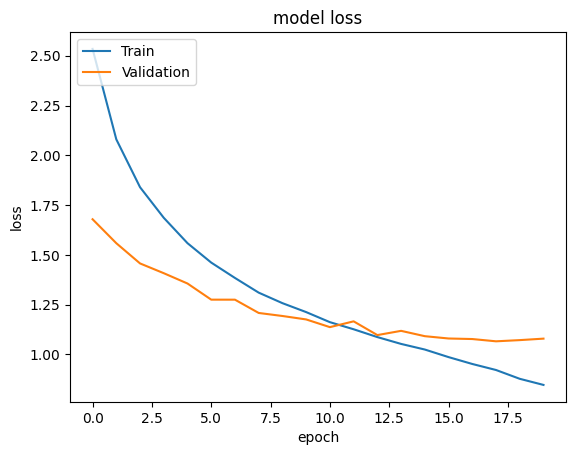

In [ ]:
print('for batchsize = ' , batch_size , ' and epochs = ' , epochs , ': ')
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
print('for batchsize = ' , batch_size , ' and epochs = ' , epochs , ': ')
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

113/113 [==============================] - 0s 4ms/step
[[231  12  38  20  99  14  53]
 [ 18  24   2   0   8   1   3]
 [ 48   3 185  20 143  47  50]
 [ 25   0  27 709  44  25  65]
 [ 48   4  68  35 374  19 105]
 [ 14   0  29  16  14 330  12]
 [ 38   2  46  40 117  14 350]]


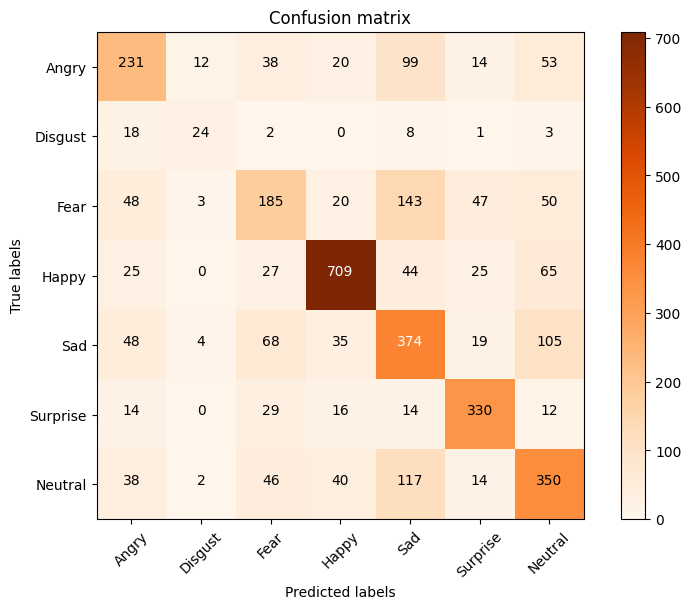

In [ ]:
modelPreds = model.predict(x_test)
from sklearn.metrics import classification_report, confusion_matrix
import itertools
modelPreds = np.argmax(modelPreds, axis=1)
new_y_test = np.argmax(y_test, axis=1)
cm = confusion_matrix(new_y_test, modelPreds)
print(cm)
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=False):
    """
    arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions
    """

    if cmap is None:
        cmap = plt.get_cmap('Oranges')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylim(len(target_names)-0.5, -0.5)
    plt.ylabel('True labels')
    plt.xlabel('Predicted labels')
    plt.savefig(title + '.png', dpi=500, bbox_inches = 'tight')
    plt.show()



# a tuple for all the class names
target_names = ('Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral')
plot_confusion_matrix(cm, target_names)